# Churn Prediction

## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import mlflow

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config
set_config(display='diagram')

from typing import List
from typing import Dict

## Setup MLFlow

In [2]:
mlflow.get_tracking_uri()

'file:///home/nsboan/projetos/mlflow-pydata-talk/notebooks/mlruns'

In [3]:
mlflow.set_tracking_uri('file:///home/nsboan/projetos/mlflow-pydata-talk/mlruns')

In [4]:
mlflow_exp = mlflow.set_experiment('churn-classification-nsb')

## Loading Data

In [5]:
df = pd.read_csv('../data/raw/customer_churn_dataset-training-master.csv')
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


None

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


## Validating Data

* <code>CustomerID</code>must be unique
* <code>Age</code> must be non-negative
* <code>Age</code> can't go above 100
* <code>Gender</code> must be one of ['Male', 'Female']
* <code>Usage Frequency</code> must be non-negative
* <code>Support Calls</code> must be non-negative
* <code>Payment Delay</code> must be non-negative
* <code>Subscription Type</code> must be one of ['Standard', 'Basic', 'Premium']
* <code>Contract Length</code> must be one of ['Annual', 'Monthly', 'Quarterly']
* <code>Total Spend</code> must be non-negative
* <code>Last Interaction</code> must be non-negative
* <code>Churn</code> must be one of [1.0, 0.0]

In [6]:
def check_non_negative(data: pd.core.frame.DataFrame, ls_columns: List[str]) -> Dict[str,bool]:
    
    results = {column:False for column in ls_columns}
    
    for column in ls_columns:
        if not data[column].min() >= 0:
            results[column] = True

    return results

def valid_value_of_list(data: pd.core.frame.DataFrame, ls_columns: List[str], rules_ls: Dict[str,list]) -> Dict[str,bool]:
    
    results = {column:False for column in ls_columns}
    
    for column in ls_columns:
        results[column] = all(df[column].isin(rules_ls[column]))
        
        if not results[column]:
            results[column] = [False,set(df[column]).symmetric_difference(rules_ls[column])]
        
    return results

In [7]:
check_non_negative(df, ['Age','Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction'])

{'Age': False,
 'Usage Frequency': False,
 'Support Calls': False,
 'Payment Delay': False,
 'Total Spend': False,
 'Last Interaction': False}

In [8]:
valid_value_of_list(df, ['Gender','Subscription Type','Subscription Type','Contract Length','Churn'],
                    {'Gender':['Male', 'Female'],
                     'Subscription Type':['Standard', 'Basic', 'Premium'],
                     'Contract Length':['Annual', 'Monthly', 'Quarterly'],
                     'Churn':[1.0,0.0]
                    })

{'Gender': [False, {nan}],
 'Subscription Type': [False, {nan}],
 'Contract Length': [False, {nan}],
 'Churn': [False, {nan}]}

In [9]:
df.CustomerID.value_counts(ascending=False)

CustomerID
2.0         1
301011.0    1
301009.0    1
301008.0    1
301007.0    1
           ..
151752.0    1
151751.0    1
151750.0    1
151749.0    1
449999.0    1
Name: count, Length: 440832, dtype: int64

In [10]:
df.Age.max()

65.0

In [11]:
print(df.shape)
df.dropna(how='any',inplace=True)
print(df.shape)

(440833, 12)
(440832, 12)


In [12]:
df.drop('CustomerID', axis=1, inplace=True)

## EDA

In [13]:
df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [14]:
df.columns = [x.lower().replace(' ', '_') for x in df.columns]

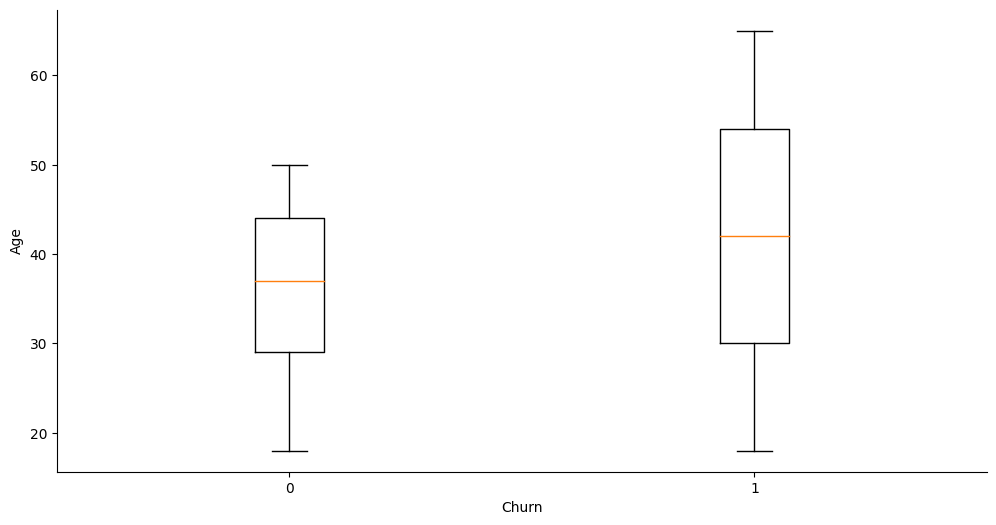

In [15]:
f_boxplot, ax = plt.subplots(figsize=(12,6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Churn')
ax.set_ylabel('Age')

ax.boxplot(df.query("churn == 0").age, positions=[0])
ax.boxplot(df.query("churn == 1").age, positions=[1])

plt.show()

<Axes: xlabel='churn', ylabel='count'>

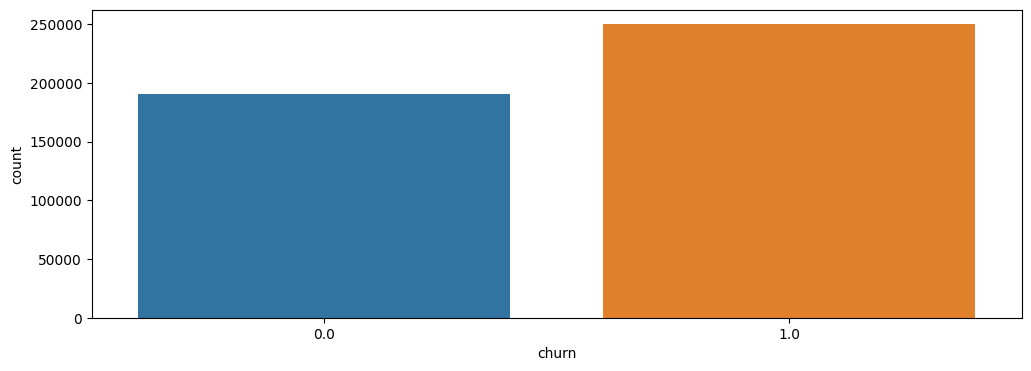

In [16]:
f_count_labels, ax = plt.subplots(figsize=(12,4))

sns.countplot(df, x='churn')

<Axes: xlabel='payment_bin', ylabel='sup_bin'>

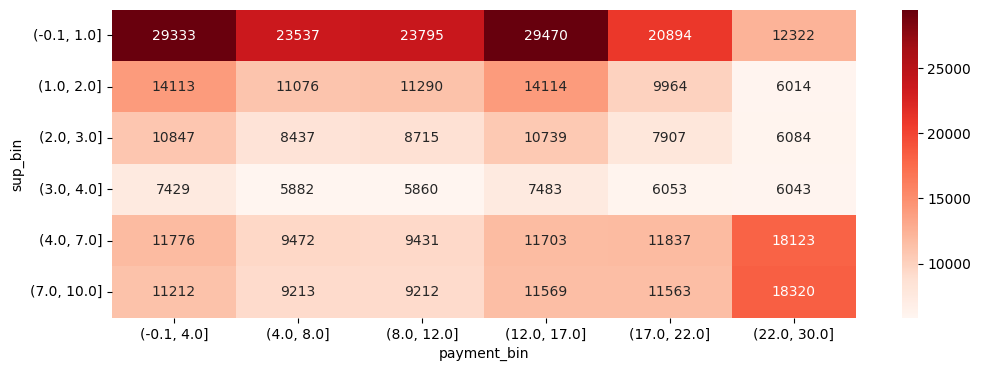

In [17]:
f_heatmap, ax = plt.subplots(figsize=(12,4))

(
    df
    .loc[:,['support_calls','payment_delay']]
    .assign(sup_bin = lambda x: pd.qcut(x.support_calls, q=6, precision=1))
    .assign(payment_bin = lambda x: pd.qcut(x.payment_delay, q=6, precision=1))
    .pivot_table(index='sup_bin', columns='payment_bin', values='support_calls', aggfunc='count')
    .pipe((sns.heatmap,'data'), annot=True, ax=ax, fmt='.0f', cmap='Reds')
)

## Model development & evaluation

In [18]:
df.head()

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [19]:
cat_cols = ['gender','subscription_type','contract_length']
num_cols = ['age', 'tenure', 'usage_frequency', 
            'support_calls', 'payment_delay', 'total_spend', 
            'last_interaction']

In [40]:
model = (
    make_pipeline(
        make_column_transformer((OrdinalEncoder(), cat_cols),(StandardScaler(), num_cols)),
        lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           max_depth=2,
                           num_leaves=2**4)
    )
)

model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['gender',
                                                   'subscription_type',
                                                   'contract_length']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'tenure',
                                                   'usage_frequency',
                                                   'support_calls',
                                                   'payment_delay',
                                                   'total_spend',
                                                   'last_interaction'])])),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=2, num_leaves=16,
                                objective='binary'))])

[LightGBM] [Info] Number of positive: 249999, number of negative: 190833
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 479
[LightGBM] [Info] Number of data points in the train set: 440832, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567107 -> initscore=0.270058
[LightGBM] [Info] Start training from score 0.270058


2023/07/19 07:34:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/nsboan/miniconda3/envs/mlflow-talk/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2023/07/19 07:34:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/nsboan/miniconda3/envs/mlflow-talk/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


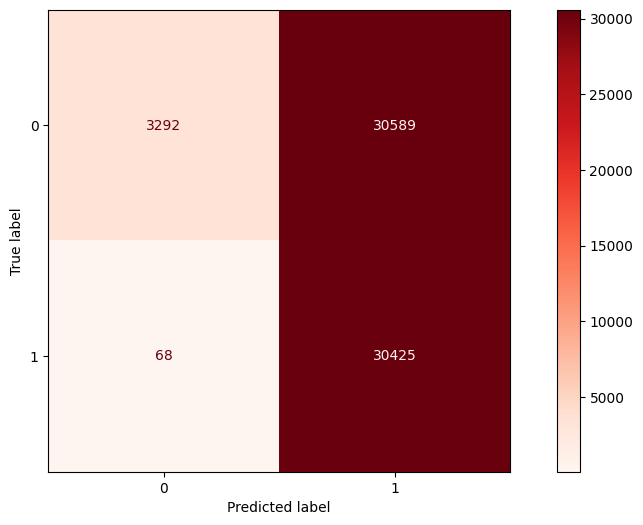

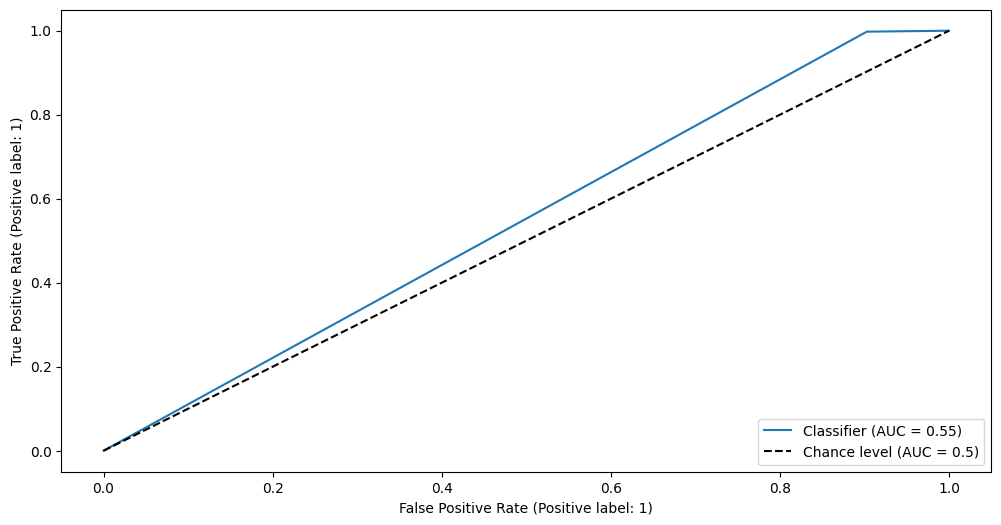

In [41]:
exp_tags = {
    'main-model':'lgbm',
    'task':'classification',
    'bp':'churn prediction'
}

with mlflow.start_run(tags=exp_tags):

    ## logging EDA figures
    mlflow.log_figure(f_count_labels,'class_counts.png')
    mlflow.log_figure(f_boxplot,'age_class_distribution.png')
    mlflow.log_figure(f_heatmap,'support_and_payment_bins.png')
    
    ## autologging the model
    mlflow.lightgbm.autolog(log_input_examples=True)
    model.fit(df.drop('churn', axis=1), df.churn)

    ## loading the test dataset
    test = (
    pd.read_csv('../data/raw/customer_churn_dataset-testing-master.csv')
    .dropna()
    .drop('CustomerID', axis=1)
    )
    
    test.columns = [x.lower().replace(' ', '_') for x in test.columns]

    ## making the predictions
    y_pred_test = model.predict(test.drop('churn', axis=1))

    ## logging the confusion matrix
    f_confusion, ax = plt.subplots(figsize=(12,6))
    ConfusionMatrixDisplay.from_predictions(test.churn, 
                                            y_pred_test, 
                                            cmap='Reds', 
                                            ax=ax,
                                            values_format='.0f')
    mlflow.log_figure(f_confusion, 'test_confusion_matrix.png')

    
    ## creating and logging the ROC AUC CURVE
    f_roc, ax = plt.subplots(figsize=(12,6))
    RocCurveDisplay.from_predictions(test.churn,
                                     y_pred_test,
                                     plot_chance_level=True,
                                     ax=ax)
    mlflow.log_figure(f_roc, 'test_roc_auc_curve.png')

    ## logging all the metricss
    metrics = {
        'accuracy':accuracy_score(test.churn, y_pred_test),
        'pos_label_precision':precision_score(test.churn, y_pred_test),
        'neg_label_precision':precision_score(test.churn, y_pred_test, pos_label=0),
        'pos_label_f1':f1_score(test.churn, y_pred_test),
        'neg_label_f1':f1_score(test.churn, y_pred_test)
    }